In [ ]:
# Importing Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,StratifiedKFold,cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier,RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score
from sklearn.metrics import roc_curve
import warnings



In [2]:
# Load Dataset
df = pd.read_csv(r"C:\Users\HP\OneDrive\Desktop\train_u6lujuX_CVtuZ9i (1).csv")
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [3]:
# Drop Loan_ID as it's not useful
df = df.drop("Loan_ID", axis=1)


In [4]:
# Handle Missing Values
df["Gender"] = df["Gender"].fillna(df["Gender"].mode()[0])
df["Married"] = df["Married"].fillna(df["Married"].mode()[0])
df["Dependents"] = df["Dependents"].fillna(df["Dependents"].mode()[0])
df["Self_Employed"] = df["Self_Employed"].fillna(df["Self_Employed"].mode()[0])
df["LoanAmount"] = df["LoanAmount"].fillna(df["LoanAmount"].median())
df["Credit_History"] = df["Credit_History"].fillna(df["Credit_History"].mode()[0])
df["Loan_Amount_Term"] = df["Loan_Amount_Term"].fillna(df["Loan_Amount_Term"].mode()[0])

In [5]:
# Encode Categorical Features
le = LabelEncoder()
for col in ['Gender', 'Married', 'Education', 'Self_Employed', 'Loan_Status']:
    df[col] = le.fit_transform(df[col])

In [6]:
# Convert '3+' to 3 and numeric 
df["Dependents"] = df["Dependents"].replace("3+","3").astype(int)

In [7]:
# One-hot encoding for Property_Area
df = pd.get_dummies(df, columns=['Property_Area'], drop_first=True)

In [8]:
df["Loan_Status"].value_counts()

Loan_Status
1    422
0    192
Name: count, dtype: int64

In [9]:
# Feature & Target
x = df.drop("Loan_Status", axis=1)
y = df["Loan_Status"]

In [10]:
# Scale Numerical Features  
num_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
scaler = StandardScaler()
x[num_cols] = scaler.fit_transform(x[num_cols])


In [11]:
# Train-Test-Split
x_train,x_test,y_train,y_test = train_test_split(
    x,y, test_size=0.2,random_state=42,stratify=y
)

In [12]:
# Handle Class Imbalance Using SMOTE
sm = SMOTE(random_state=42)
x_res, y_res = sm.fit_resample(x_train, y_train)

In [13]:
# Define Stratified K-Fold
sk = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)

In [ ]:
# Model 1:- XGBOOST

xgb = XGBClassifier(random_state=42,eval_metric="logloss",use_label_encoder=False)
param_grid = {
    "n_estimators":[100,150,200],
    "max_depth":[3,4,5],
    "learning_rate":[0.1,0.01,0.5,0.05],
    "colsample_bytree":[0.6,0.7,0.8,0.9],
    "subsample":[0.6,0.7,0.8,0.9],
    "gamma":[0.6,0.7,0.8,0.9],
    "reg_lambda":[1,2,3],
    "reg_alpha":[0.8,1]
}
grid_xgb = RandomizedSearchCV(xgb,param_grid,cv=sk,n_jobs=-1,scoring="roc_auc",
n_iter=20,random_state=42)
grid_xgb.fit(x_res,y_res)
print(grid_xgb.best_score_)
best_xgb = grid_xgb.best_estimator_

0.8354107425995572


c:\Users\HP\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:42:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
# Model 2:- LightBoost

lgb = LGBMClassifier(random_state=42,verbose=0)
param_grid = {
    "max_depth":[2,3,4,5],
    "n_estimators":[100,150,200],
    "learning_rate":[0.1,0.01,0.5,0.05]

}
grid_lgb = RandomizedSearchCV(lgb,param_grid,cv=sk,n_iter=20,scoring="roc_auc",n_jobs=-1,random_state=42)
grid_lgb.fit(x_res,y_res)
best_lgb = grid_lgb.best_estimator_



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [ ]:
# Model 3:- CatBoost
cat = CatBoostClassifier(eval_metric="AUC",random_seed=42,verbose=0)
param_grid = {
    "iterations":[100,500,800],
    "learning_rate":[0.1,0.5,0.01,0.05],
    "depth":[4,5,6]
}
grid_cat = RandomizedSearchCV(cat,param_grid,cv=sk,n_jobs=-1,scoring="roc_auc"
,n_iter=20,random_state=42)
grid_cat.fit(x_res,y_res)
print(grid_cat.best_score_)
best_cat = grid_cat.best_estimator_

0.8618282599295009


In [20]:
# Model 4:- Random Forest(Meta Model)
rf = RandomForestClassifier(random_state=42,class_weight="balanced")
param_grid = {
    "max_depth":[2,3,4,5],
    "min_samples_split":[2,5,10],
    "min_samples_leaf":[2,4,6,8],
    "n_estimators":[100,150,200]
}
grid_rf = RandomizedSearchCV(rf,param_grid,cv=sk,n_iter=20,n_jobs=-1,scoring="roc_auc",random_state=42)
grid_rf.fit(x_res,y_res)

print(grid_rf.best_score_)
best_rf = grid_rf.best_estimator_


0.8302818654750828


In [21]:
# Model 5:- Decision Tree
dt = DecisionTreeClassifier(random_state=42,class_weight="balanced")
param_grid = {
    "max_depth":[2,3,4,5],
    "min_samples_split":[2,5,10],
    "min_samples_leaf":[2,4,6],
  
}
grid_dt = RandomizedSearchCV(dt,param_grid,n_iter=20,cv=sk,scoring="roc_auc",random_state=42,n_jobs=-1)
grid_dt.fit(x_res,y_res)
print(grid_dt.best_score_)
best_dt = grid_dt.best_estimator_


0.7744499626538073


In [23]:
# Bulid Stacking Ensemble
base_model = [
    ("cat",best_cat),
    ("xgb",best_xgb),
    ("lgb",best_lgb),
    ("dt",best_dt)
]
meta_model = best_rf
stack = StackingClassifier(estimators=base_model,
final_estimator=meta_model,passthrough=True,cv=5,n_jobs=-1)
stack.fit(x_res,y_res)


StackingClassifier(cv=5,
                   estimators=[('cat',
                                <catboost.core.CatBoostClassifier object at 0x0000024117E6A450>),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.7, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_w...
                                LGBMClassifier(learning_rate=0.05, max_depth=5,
                                               random_state=42, verbose=0)),
                               ('dt',
                                DecisionTreeClassifier(class_weight='balanced',
                                                       max_depth=4,
                                                       min_samples_leaf=6,
                                                       min_samples_split=10,
                                                       random_state=42))],
                   final_estimator=RandomForestClassifier(class_weight='balanced',
                                                          max_depth=4,
                                                          min_samples_leaf=2,
                                                          n_estimators=150,
                                                          random_state=42),
                   n_jobs=-1, passthrough=True)

In [24]:
# Evaluation on Test Data
y_prd = stack.predict(x_test)
y_proba = stack.predict_proba(x_test)[:,1]
print("Accuracy:",accuracy_score(y_test,y_prd))
print("ROC-AUC:",roc_auc_score(y_test,y_proba))
print(classification_report(y_test, y_prd))

Accuracy: 0.8211382113821138
ROC-AUC: 0.7857585139318886
              precision    recall  f1-score   support

           0       0.72      0.68      0.70        38
           1       0.86      0.88      0.87        85

    accuracy                           0.82       123
   macro avg       0.79      0.78      0.79       123
weighted avg       0.82      0.82      0.82       123



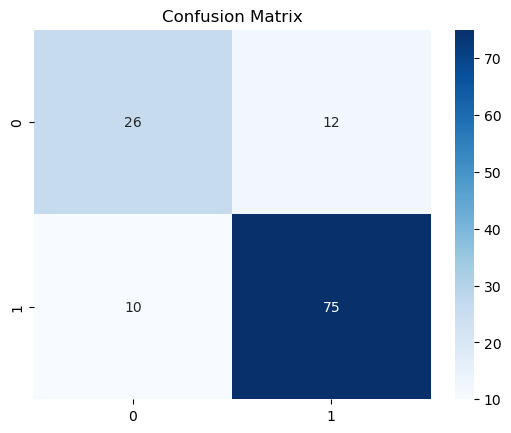

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_prd)
cm
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [26]:
# Cross-Validation Score on Full Data
cv_score = cross_val_score(stack, x, y, cv=sk, n_jobs=-1, scoring="roc_auc")
print("Cross-Validation ROC-AUC:", cv_score.mean())

Cross-Validation ROC-AUC: 0.7625856685454209


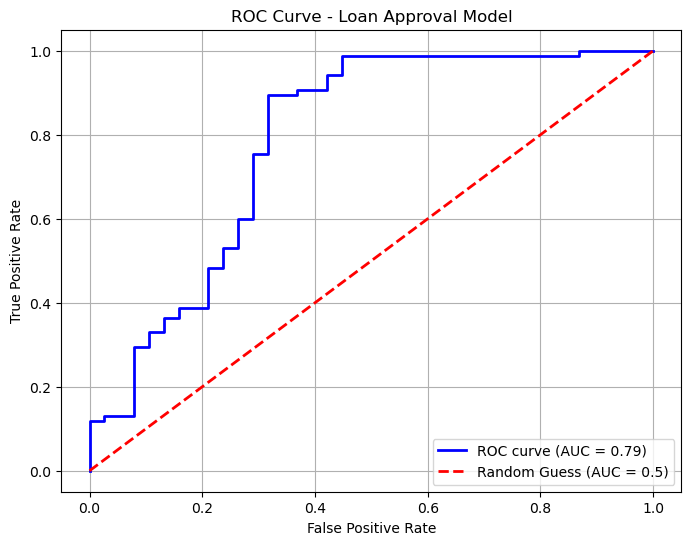

In [27]:
# ROC-AUC curve plot
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guess (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Loan Approval Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
